In [26]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import h5py
from tqdm import tqdm
from scipy.stats import norm
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, UpSampling2D, Activation, MaxPooling2D, Dropout, Flatten
from keras.layers import Dense, Reshape, Lambda, Layer
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img, img_to_array
from keras import metrics


In [12]:
datagen = ImageDataGenerator(
            rotation_range=5,
            width_shift_range=0.1,
            height_shift_range=0.1,
            rescale=1./255,
            shear_range=0.1,
            zoom_range=0.1,
            horizontal_flip=False,
            fill_mode='nearest',
            data_format="channels_last")

### Based off of

https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder.py
https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder_deconv.py

In [13]:
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0


x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)


# Custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean):
        xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x

/home/carson/Documents/code/ml-testing/.env/lib/python3.5/site-packages/ipykernel_launcher.py:52: UserWarning: Output "custom_variational_layer_2" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_2" during training.


NameError: name 'mnist' is not defined

In [ ]:
y = CustomVariationalLayer()([x, x_decoded_mean])
vae = Model(x, y)
vae.compile(optimizer='rmsprop', loss=None)

In [ ]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

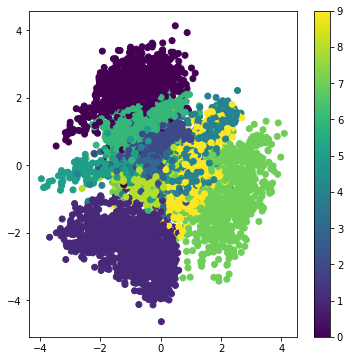

In [30]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

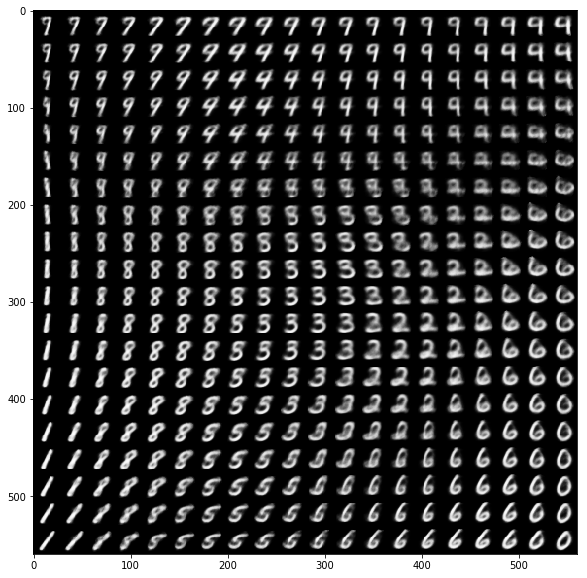

In [29]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

# display a 2D manifold of the digits
n = 20  # figure with 20x20 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()